# Elevation profile

Understanding how pycraf calculates path loss begins with calculating path profiles. The output below closely resembles the output seen in visualyse.

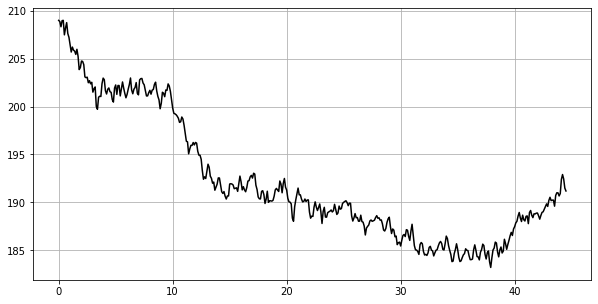

In [1]:
import matplotlib.pyplot as plt
from pycraf import pathprof
from astropy import units as u

pathprof.SrtmConf.set(srtm_dir='C:\SRTM', download='missing', server='viewpano')

# Tx and Rx points
lonTx, latTx = 127.575535 * u.deg, -30.445137 * u.deg
lonRx, latRx = 127.480696 * u.deg, -30.837683 * u.deg

# Profile granularity
hprof_step = 100 * u.m

(lons, lats, distance, distances,heights, bearing, back_bearing, back_bearings) = pathprof.srtm_height_profile (lonTx, latTx, lonRx, latRx, hprof_step)

_distances = distances.to(u.km).value
_heights = heights.to(u.m).value

plt.figure(figsize=(10,5))
plt.plot(_distances, _heights, '-k')
plt.grid()

# Propagation Loss Maps

The fastest way to calculate the DBC is to work from pycraf's ability to create maps of propagation loss. Below is an example scenario.

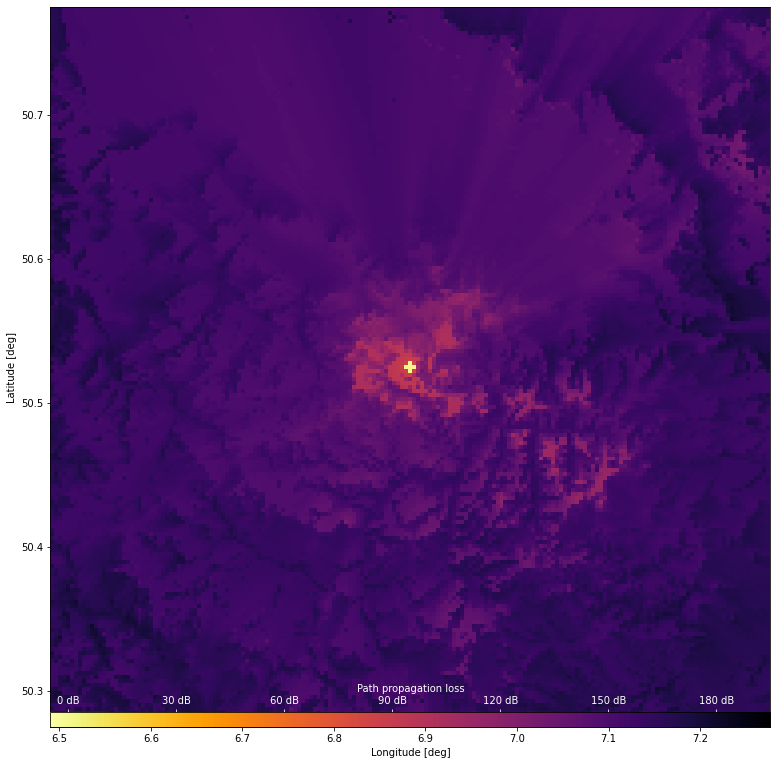

In [4]:
from pycraf import pathprof, conversions as cnv
from astropy import units as u
import numpy as np

def plot_atten_map(lons, lats, total_atten):

    import matplotlib.pyplot as plt

    vmin, vmax = -5, 195
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes((0., 0., 1.0, 1.0))
    cbax = fig.add_axes((0., 0., 1.0, .02))
    cim = ax.imshow(
        total_atten,
        origin='lower', interpolation='nearest', cmap='inferno_r',
        vmin=vmin, vmax=vmax,
        extent=(lons[0], lons[-1], lats[0], lats[-1]),
        )
    cbar = fig.colorbar(
        cim, cax=cbax, orientation='horizontal'
        )
    ax.set_aspect(abs(lons[-1] - lons[0]) / abs(lats[-1] - lats[0]))

    ctics = np.arange(0, vmax, 30)
    cbar.set_ticks(ctics)
    cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
    cbar.set_label(r'Path propagation loss', color='w')
    cbax.xaxis.tick_top()
    cbax.tick_params(axis='x', colors='w')
    cbax.xaxis.set_label_position('top')

    ax.set_xlabel('Longitude [deg]')
    ax.set_ylabel('Latitude [deg]')

    plt.show()

lon_tx, lat_tx = 6.88361 * u.deg, 50.52483 * u.deg
map_size_lon, map_size_lat = 0.5 * u.deg, 0.5 * u.deg
map_resolution = 10. * u.arcsec

freq = 1. * u.GHz
omega = 0. * u.percent  # fraction of path over sea
temperature = 290. * u.K
pressure = 1013. * u.hPa
timepercent = 2 * u.percent  # see P.452 for explanation
h_tg, h_rg = 50 * u.m, 10 * u.m
G_t, G_r = 0 * cnv.dBi, 0 * cnv.dBi
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN
hprof_step = 100 * u.m

hprof_cache = pathprof.height_map_data(
    lon_tx, lat_tx,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    zone_t=zone_t, zone_r=zone_r,
    )  # dict-like

results = pathprof.atten_map_fast(
    freq,
    temperature,
    pressure,
    h_tg, h_rg,
    timepercent,
    hprof_cache,
    )

lons = hprof_cache['xcoords']
lats = hprof_cache['ycoords']
# index 4 is total loss without clutter/gain included:
total_atten = results['L_b'].value

plot_atten_map(lons, lats, total_atten)